100%|██████████| 1166/1166 [00:01<00:00, 1009.90it/s]


(0.004287123072127624,
 tensor([[0.],
         [0.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]]),
 tensor([[1.2458e-14],
         [1.3099e-34],
         [1.0000e+00],
         ...,
         [0.0000e+00],
         [4.8048e-33],
         [0.0000e+00]]))

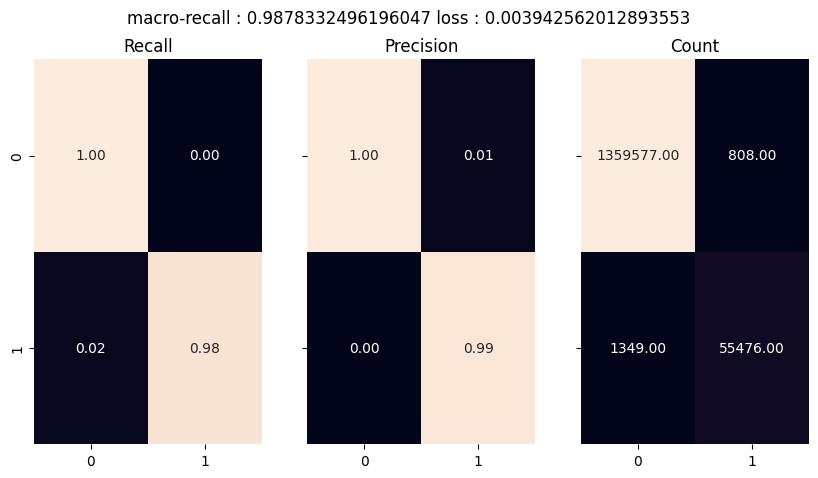

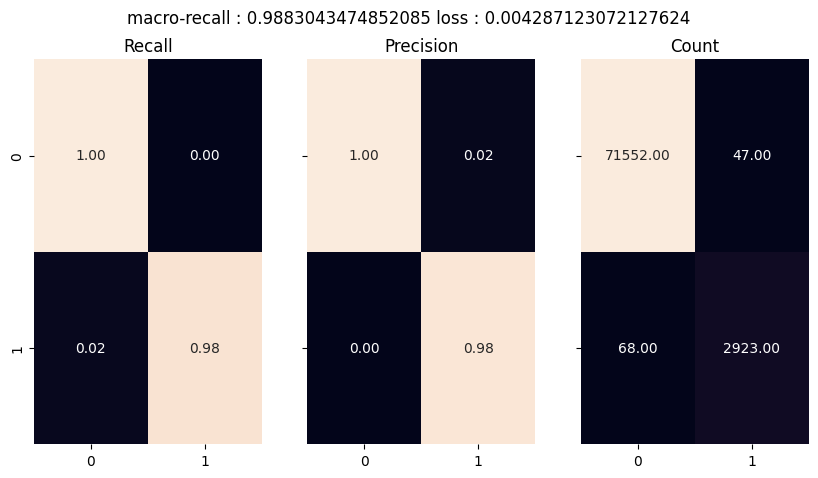

In [6]:
import torch
from torch import nn
from tqdm import tqdm

from lib.utils import *
from lib.models import *

window_size = 101
device = 'cuda'
model = FCN()
model.load_state_dict(torch.load(f=f'../fcn_cv_4/best_model.pt',map_location='cuda:0'))
trainloader,devloader,test_idx = load_data_convolution_cv(foldi=4)
model.to(device)

criterion = nn.BCEWithLogitsLoss()

test_evaluation(trainloader,model,criterion,dir=f'.',filename='train.jpg',device=device)
test_evaluation(devloader,model,criterion,dir=f'.',filename='dev.jpg',device=device)

In [ ]:
from sklearn.metrics import f1_score,recall_score,precision_score
f1i = []
recalli = []
precisioni = []
for idx in test_idx:
    X,y = load_and_window_nursing_list([idx])
    loss,y_true,y_pred = test_evaluation(DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True),model,criterion,plot=True)
    f1i.append(f1_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
    recalli.append(recall_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
    precisioni.append(precision_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))

In [ ]:
sns.kdeplot(recalli,bw_adjust=.4)
sns.rugplot(recalli)
print(torch.tensor(recalli).mean()) #.4958
print(torch.tensor(recalli).std()) #.0063

In [ ]:
sns.kdeplot(f1i,bw_adjust=.4)
sns.rugplot(f1i)
print(torch.tensor(f1i).mean()) #.4958
print(torch.tensor(f1i).std()) #.0063

In [ ]:
sns.kdeplot(precisioni,bw_adjust=.4)
sns.rugplot(precisioni)
print(torch.tensor(precisioni).mean()) #.4958
print(torch.tensor(precisioni).std()) #.0063

100%|██████████| 12863/12863 [00:10<00:00, 1269.32it/s]


0.9888223567535075
0.9856795464096595
0.9920097413915223


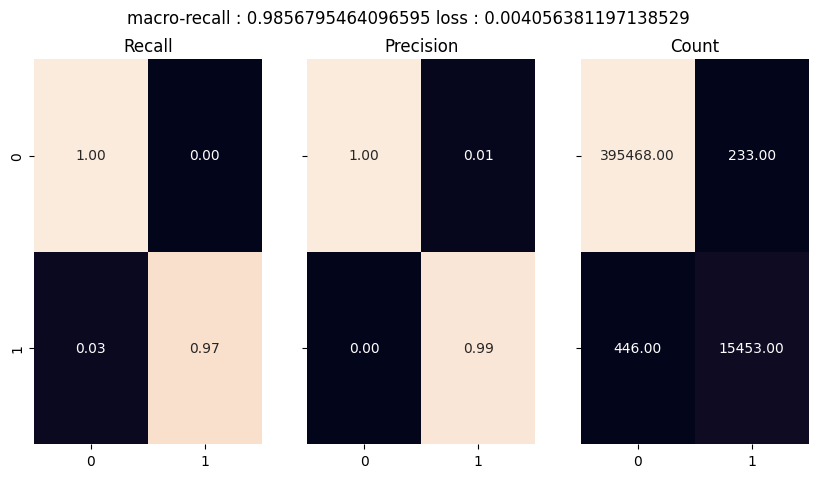

In [8]:
from sklearn.metrics import f1_score,recall_score,precision_score
X,y = load_and_window_nursing_list_for_convolution(test_idx)
loss,y_true,y_pred = test_evaluation(DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True),model,criterion,plot=True,filename='fcn')
print(f1_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
print(recall_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
print(precision_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))

In [9]:
idx = test_idx[0]
import plotly.express as px
holdoutloader = DataLoader(TensorDataset(*load_and_window_nursing_list_for_convolution([idx])),batch_size=32,shuffle=False)
loss,y_true,y_pred = test_evaluation(holdoutloader,model,criterion)
X,y = load_nursing_by_index(idx)
df = pd.DataFrame(X.numpy())
df['y_pred'] = torch.cat([torch.zeros(window_size//2),y_pred.flatten().round(),torch.zeros(window_size//2)])*10
df['y_true'] = y*10
fig = px.line(df)
fig.show(renderer='browser')

  0%|          | 0/1010 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [128, 3, 8], expected input[1, 32, 303] to have 3 channels, but got 32 channels instead